In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/semester2/CV/dogs")


In [ ]:
#!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz

In [ ]:
#!tar -xf  imagewoof2.tgz 


Процесс исследования задачи был следующий.    
1)  Работаем с правильными метками noise_labels_0
Прогоняю три варианта:   
*   классификация с помощью resnet50 на первоначальном изображении

*   детектирование собаки, получение bbox c помощью maskrcnn, обрезаю картинку по bbox с максимальным confidence, затем классификация resnet50
*   детектирование и получение маски mask и bbox c помощью maskrcnn, накладываю маску по классу собака, обрезаю картинку по bbox с максимальным confidence, затем классификация resnet50    

Данное исследование по факту сильный прирост не дало. Но все равно решаю оставить последний вариант.   

2) Обрабатываю все файлы val и train и получаю новые файлы +"_mask" последним способом

3) Добавляю трансформации  ShiftScaleRotate, RandomBrightnessContrast,     RandomGamma, Blur, GaussNoise,  HorizontalFlip

4) Экспериментирую с сетками resnet50, resnext50_32x4d(pretrained=True). Обучение произвожу со всеми размороженными слоями.
Для правильных меток получаю лучший результат 89%


5) Теперь разберемся с неправильными метками. Насколько я поняла, неправильная разметка касается только обучающего датасета, на валидации разметка корректная.  

Глубиной анализа похвастаться не получиться :). Гипотеза следующая: предположим, что сеть первоначально учится на правильных метках и максимальная ошибка будет первоначально на неправильных метках. 
Обучаемся несколько эпох, затем сортируем полученные результаты по вероятности правильного класса на каждой картинке. отбираем самые худшие результаты, запоминаем и удаляем из обучения. Количество удаленных картинок подбираем экспериментально (так как насколько плохая разметка мы на практике не можем знать), оно зависит от процента неправильных меток (процент * общее количество картинок). В случае 5 процентов берем с запасом 1000. в случае 25 процентов - 2000 образцов, 50% - 3000

Результаты получились такие:   

0% - accuracy = 89%     

5% - accuracy = 88%    

25% - accuracy = 84%    

50% - accuracy = 73%  




# Создание датасетов, dataloaders, функций для обучения и валидации

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from  scipy import stats
import scipy
import cv2

import torch.optim as optim
import torchvision.models as models
from tqdm.notebook import tqdm
from torch.nn import functional as fnn

np.random.seed(1)
torch.manual_seed(1)
random.seed(1)
import pandas as pd
import PIL
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.data_path = "/content/drive/MyDrive/MADE/semester2/CV/contest02/data/"
    self.epochs = 2
    self.batch_size = 64
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=1e-3
    self.learning_rate_gamma=None
    self.weight_bce=1
    self.load=None
    self.gpu = True
    self.output_dir="/content/drive/MyDrive/MADE/Project/RACNN_models/"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()   

In [ ]:
NUM_CLASSES = 10
CROP_SIZE = 224
NAMES = ['Golden retriever', 'Border terrier', 'English foxhound', 'Australian terrier', 'Beagle', 'Rhodesian ridgeback', 'Shih-Tzu', 'Dingo','Old English sheepdog','Samoyed' ]
device = torch.device("cuda:0") if args.gpu and torch.cuda.is_available() else torch.device("cpu")

In [ ]:
files_glob = []

In [ ]:
import glob
class DogsDataset(Dataset):
    def __init__(self, root, transforms, split="train", iskl_names = [], noise_level = 0):
        super(DogsDataset, self).__init__()
        self.root = root 
        self.image_names = []
        self.transforms = transforms
        self.labels = []

      
        dirs = ['n02099601', 'n02093754', 'n02089973', 'n02096294', 'n02088364', 'n02087394', 'n02086240', 'n02115641', 'n02105641', 'n02111889']

        files = glob.glob(os.path.join(root, f"{split}/*/*.JPEG"))
       
        
        print(len(files))
        for filename in files[:]:
            #print(filename)
            if filename[7:] in iskl_names:
              #print('**')
              continue
            self.image_names.append(filename[7:])
            
        if split == 'train':
            #dirs = [dirs[i][13:] for i in range(10)]
            #print(dirs)
            labels =  pd.read_csv(os.path.join(f"{root}/noisy_imagewoof.csv"))
            print(labels.head())
            labels_dict = {k: dirs.index(v) for k, v in zip(labels['path'].values, labels['noisy_labels_'+ str(noise_level)].values)}
            print(labels_dict)
        else:
            #dirs = [dirs[i][11:] for i in range(10)]
            #print(dirs)
            labels = [self.image_names[i][4:13]  for i in range(len(self.image_names))]
            print(labels)
            labels_dict = {k: dirs.index(v) for k, v in zip(self.image_names, labels)}
            print(labels_dict)
                 
                 
        self.labels_dict = labels_dict 
        
        
        for image_name in self.image_names:
            #print(filename)
           
            self.labels.append(self.labels_dict[image_name])
  
    def __getitem__(self, idx):
        
        sample = {}
    
        image = cv2.imread((os.path.join(self.root, self.image_names[idx] + "_mask")))
        #print(self.image_names[idx])
        # #print(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image
        #sample['label'] = self.labels_dict[self.image_names[idx]]
        sample['label'] = self.labels[idx]
        sample['id'] = idx
        if self.transforms is not None:
             sample = self.transforms(sample)

        #print(sample)
        return sample

    def __len__(self):
        return len(self.image_names)

In [ ]:
class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        # self.size = torch.tensor(size, dtype=torch.float)
        self.size = np.asarray(size, dtype=np.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

       

        return sample


class CropCenter(object):
    def __init__(self, size=128, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
       # sample["crop_margin_x"] = margin_w
       # sample["crop_margin_y"] = margin_h

    
        return sample
        
class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample

In [ ]:
from torchvision import transforms
import albumentations


class apply_albumentations(object):
    def __init__(self, augmenter):
        self.augmenter = augmenter


    def __call__(self, sample):
        #print(sample)
        #print(self.augmenter)
        sample['image'] = self.augmenter(image=np.array(sample['image']))["image"]
        #plt.imshow(sample['image'])
        return sample

augmenter = albumentations.Compose([
    albumentations.ShiftScaleRotate(rotate_limit=25, p=0.7),
    albumentations.RandomBrightnessContrast(p=0.4),
    albumentations.RandomGamma(p=0.4),
    albumentations.Blur(blur_limit=2, p=0.1),
    albumentations.GaussNoise((10, 100), p=0.2),
    albumentations.HorizontalFlip(p=0.5)
])


train_transforms = transforms.Compose([
        apply_albumentations(augmenter),                                
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        #TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),#
        TransformByKeys(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ("image",))
])

val_transforms = transforms.Compose([
                                
        ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
        CropCenter(CROP_SIZE),
        TransformByKeys(transforms.ToPILImage(), ("image",)),
        TransformByKeys(transforms.ToTensor(), ("image",)),
        #TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]), ("image",)),#
        TransformByKeys(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ("image",))
])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [ ]:
def train(model, loader, loss_fn, optimizer, device,scheduler):
    model.train()
    train_loss = []
    print_loss = [] 
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)#, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    for i, batch in enumerate(tqdm(loader, total=len(loader), desc="training...", position=0 , leave = True)):
        #print(batch)
        images = batch["image"].to(device) 
        labels = batch["label"]  

        pred_labels = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_labels, labels)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print_loss.append(loss.item())
        if (i + 1) % 20 == 0:
            mean_loss = np.mean(print_loss)
            #print(f'Loss: {mean_loss:.7f}')
            scheduler.step(mean_loss)
            print_loss = [] 
        
        
    return np.mean(train_loss)


def validate(model, loader, loss_fn, device):
   model.eval()
   val_mse_loss = []
   val_loss = []
   for batch in tqdm(loader, total=len(loader), desc="validation..."):
       #print(batch["image"].shape)
       images = batch["image"].to(device)
       labels = batch["label"]

       with torch.no_grad():
           pred_labels = model(images).cpu()
           loss = loss_fn(pred_labels, labels)
       val_loss.append(loss.item())
   return (np.mean(val_loss))   



In [ ]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
def calculate_predictions(model, loader):
    model.eval()
    epoch_loss = 0
    history = []
    real = []
    pred = []
    ids = []
    scores = []
    with torch.no_grad():

        for batch in tqdm(loader, total=len(loader), desc="validation..."):
             images = batch["image"].to(device)
             labels = batch["label"]
             idx = batch["id"]

         

             pred_labels = model(images).cpu()
             labels_pred = pred_labels.argmax(1)

            
             real.extend(labels)
             pred.extend(labels_pred) 
             ids.extend(idx)
             #print(pred_labels.shape)
             #print(pred_labels[range(32), labels].shape)
             
             if labels.shape[0] == args.batch_size:
                   scores.extend(list(pred_labels[range(args.batch_size), labels].numpy()))
             
        #print(accuracy_score(real, pred)) 
        print(confusion_matrix(real, pred))  
        print(classification_report(real, pred))  
        #f1 = ((f1_score(real, pred, average = 'binary', pos_label = 0))  + (f1_score(real, pred, average = 'binary', pos_label = 1)))/2
        return (accuracy_score(real, pred)), ids, real, pred , scores
        #plt.hist(real)

#Сегментирование и обрезание картинок по bbox

In [ ]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

  
    
    return model

In [ ]:
COCO_CLASS_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
device = torch.device("cuda:0") if args.gpu and torch.cuda.is_available() else torch.device("cpu")

In [ ]:
TRESHOLD_MASK = 0.05

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()

def val_transform(img):
    img_tensor = to_tensor(img) # делаем тензор с 3 каналами из изображением
    return img_tensor.unsqueeze(0) # добавляем четвертую размерность  - перввое
    # измерение -  количество сеймплов в батче



In [ ]:
TRESHOLD_MASK = 0.05
def visualize_prediction_mask(file, model, device='cuda', verbose=True, thresh=0.0,
                         n_colors=None):
    #читаем файл, лучше чем opencv
    img = Image.open(file)
    img_tensor = val_transform(img)
    model.to(device)
    #eval режим
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.to(device))  # list of size 1
    prediction = predictions[0]

    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features

    palette = sns.color_palette(None, n_colors)

    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    for i in range(len(prediction["boxes"])):
        
        x1, x2, x3, x4 = map(int, prediction["boxes"][i].tolist())
        label = int(prediction["labels"][i].cpu())
        if label != 18:
          continue
        #print(label)
        score = float(prediction["scores"][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = COCO_CLASS_NAMES[label]
        color = palette[label]
        if verbose:
            if score > thresh:
                print ("Class: {}, Confidence: {}".format(name, score))
        if score > thresh:
            image = cv2.rectangle(img.copy(), (x1, x2), (x3, x4),
                                  np.array(color) * 255, 2)
            cv2.putText(image, name, (x1, x2-10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, np.array(color) * 255, 2)
            image_segmented = img.copy()
            image_segmented[mask < TRESHOLD_MASK] = (250, 250, 250)
            image_segmented = image_segmented[x2 : x4, x1 : x3]
            
            show_image(image_segmented)
    #show_image(image)
    return prediction

In [ ]:

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Class: dog, Confidence: 0.9868466258049011


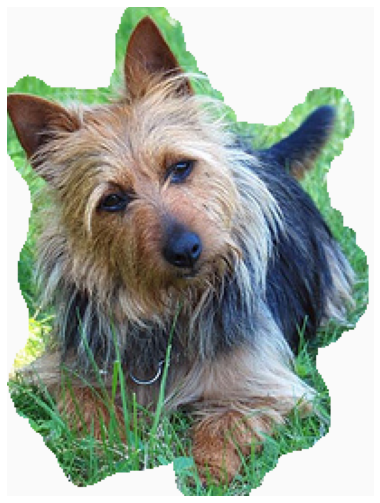

In [ ]:
_ = visualize_prediction_mask(os.path.join("./data/", np.random.choice(train_dataset.image_names)), model, device)

In [ ]:
def save_dog_file(file, mask_model, device='cuda', verbose=True, thresh=0.0, n_colors=None):
    #читаем файл, лучше чем opencv
    img1 = Image.open(file)
    if img1.mode != 'RGB':
      print("***")
    #print(img.mode)
    
    img_tensor = val_transform(img1)
    #print(img_tensor.shape)
    mask_model.to(device)
    #eval режим
    mask_model.eval()
    with torch.no_grad():
        predictions = mask_model(img_tensor.to(device))  # list of size 1
    prediction = predictions[0]

    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features

    palette = sns.color_palette(None, n_colors)

    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    #show_image(img)
    score_max = 0
    found = False
    for i in range(len(prediction["boxes"])):
        
        x1, x2, x3, x4 = map(int, prediction["boxes"][i].tolist())
        label = int(prediction["labels"][i].cpu())
        if label != 18:
          continue
        #print(label)
        score = float(prediction["scores"][i].cpu())
        name = COCO_CLASS_NAMES[label]
        color = palette[label]
        #if verbose:
            #if score > thresh:
                #print ("Class: {}, Confidence: {}".format(name, score))
        if score > thresh:
            if score > score_max:
              score_max = score
              x1_max, x2_max, x3_max, x4_max = x1, x2, x3, x4
              mask = prediction['masks'][i][0, :, :].cpu().numpy()
              found = True
              #print(x1_max, x2_max, x3_max, x4_max)
    
    if (found == True) and (img1.mode == 'RGB') :
            if (mask.shape[0] != img.shape[0]) or(mask.shape[1] != img.shape[1])  :
                print("1111")
                image = img
                isWritten = cv2.imwrite(file + "_mask", image)  
                return
            #print("11")
            #image = cv2.rectangle(img.copy(), (x1_max, x2_max), (x3_max, x4_max),
                        #              np.array(color) * 255, 2)
            #show_image(image)
            #print(mask.shape, img.shape)
            img[mask < TRESHOLD_MASK] = (0, 0, 0)
            image = img[x2_max : x4_max, x1_max : x3_max,]
            
            #show_image(image)
            isWritten = cv2.imwrite(file + "_mask", image)      
    else:
            image = img
            isWritten = cv2.imwrite(file + "_mask", image)   
    #print(isWritten)                       
    #show_image(image)
    #return prediction

In [ ]:
import glob
class DogsDataset(Dataset):
    def __init__(self, root, transforms, split="train"):
        super(DogsDataset, self).__init__()
        self.root = root
        self.image_names = []
        self.transforms = transforms
        self.labels = []
        mask_model = get_detector_model()
        # model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
        mask_model.to(device);

        #dirs = glob.glob(os.path.join(root, f'{split}/*'))
        #print(dirs)
        dirs = ['n02099601', 'n02093754', 'n02089973', 'n02096294', 'n02088364', 'n02087394', 'n02086240', 'n02115641', 'n02105641', 'n02111889']

        files = glob.glob(os.path.join(root, f"{split}/*/*.JPEG"))
        
        #print(len(files))
        for filename in tqdm(files[:]):
           # print(filename)
            save_dog_file(filename, mask_model)
            
            self.image_names.append(filename[7:])
            #break
            
        if split == 'train':
            #dirs = [dirs[i][13:] for i in range(10)]
            #print(dirs)
            labels =  pd.read_csv(os.path.join(f"{root}/noisy_imagewoof.csv"))
            #print(labels.head())
            labels_dict = {k: dirs.index(v) for k, v in zip(labels['path'].values, labels['noisy_labels_0'].values)}
            #print(labels_dict)
        else:
            #dirs = [dirs[i][11:] for i in range(10)]
            #print(dirs)
            labels = [self.image_names[i][4:13]  for i in range(len(self.image_names))]
            #print(labels)
            labels_dict = {k: dirs.index(v) for k, v in zip(self.image_names, labels)}
            #print(labels_dict)
                 
                 
        self.labels_dict = labels_dict 
        
        
        for image_name in self.image_names:
            #print(filename)
           
            self.labels.append(self.labels_dict[image_name])
  
    def __getitem__(self, idx):
        
        sample = {}
        # if self.landmarks is not None:
        #     landmarks = self.landmarks[idx]
        #     sample["landmarks"] = landmarks

        # #print(self.image_names[idx])
        image = cv2.imread((os.path.join(self.root, self.image_names[idx])))
        #print(self.image_names[idx])
        # #print(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image
        #sample['label'] = self.labels_dict[self.image_names[idx]]
        sample['label'] = self.labels[idx]
        if self.transforms is not None:
             sample = self.transforms(sample)

        #print(sample)
        return sample

    def __len__(self):
        return len(self.image_names)

In [ ]:

train_dataset = DogsDataset('./data/', train_transforms, split="train")
val_dataset = DogsDataset('./data/', train_transforms, split="val")

#Обучение классификационных моделей

## Обучение модели 25 %

In [ ]:
#@title assist functions 
def get_training_set():
          model = models.resnext50_32x4d(pretrained=True)
          model.requires_grad_(True)

          model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES, bias=True)
          model.fc.requires_grad_(True)

          for param in model.parameters():
            param.requires_grad = True

          for param in model.fc.parameters():
            param.requires_grad = True

          model.to(device)

          optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=0.00001, amsgrad=True)
          loss_fn =  nn.CrossEntropyLoss(reduce = 'mean')
          scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)
          return model, optimizer,  loss_fn, scheduler


def train_model(name_model,  noise_level, iskl_amount):
          iskl_names = []
          train_dataset = DogsDataset('./data/', train_transforms, "train", iskl_names, noise_level)
          val_dataset = DogsDataset('./data/', val_transforms, split="val")
          train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=True, drop_last=True)
          val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=False, drop_last=False)
          
          model, optimizer,  loss_fn, scheduler = get_training_set()
          # model = models.resnext50_32x4d(pretrained=True)
          # model.requires_grad_(True)

          # model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES, bias=True)
          # model.fc.requires_grad_(True)

          # for param in model.parameters():
          #   param.requires_grad = True

          # for param in model.fc.parameters():
          #   param.requires_grad = True

          # model.to(device)

          # optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=0.00001, amsgrad=True)
          # loss_fn =  nn.CrossEntropyLoss(reduce = 'mean')
          # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)
          
          args.epochs = 3
          # 2. train & validate
          print("FIRST TRAINING TO FIND BAD LABELS")
          best_val_loss = np.inf
          for epoch in range(args.epochs):
              train_loss = train(model, train_dataloader, loss_fn, optimizer, device, scheduler)
              val_loss = validate(model, val_dataloader, loss_fn, device=device)
              print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
              if val_loss < best_val_loss:
                  best_val_loss = val_loss
                  with open(os.path.join("runs", name_model), "wb") as fp:
                      torch.save(model.state_dict(), fp)


          print("FILTER BAD LABELS")
          with open(os.path.join("runs", name_model), "rb") as fp:
                best_state_dict = torch.load(fp, map_location="cpu")
                model.load_state_dict(best_state_dict)   
          acc, idx, real, pred, scores = calculate_predictions(model, train_dataloader)    
          iskl_names = np.array(train_dataset.image_names)[np.argsort(scores)][0:iskl_amount]     
          print(len(iskl_names))
          print(iskl_names)
          train_dataset1 = DogsDataset('./data/', train_transforms, "train", iskl_names, noise_level)
          train_dataloader1 = DataLoader(train_dataset1, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=True, drop_last=True)  
          print(len(train_dataset1.image_names))

          model, optimizer,  loss_fn, scheduler = get_training_set()

          print("SECOND TRANING WITHOUT BAD LABELS")                       
          for epoch in range(3):
                  train_loss = train(model, train_dataloader1, loss_fn, optimizer, device, scheduler)
                  
                  val_loss = validate(model, val_dataloader, loss_fn, device=device)
                  print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
                  if val_loss < best_val_loss:
                      best_val_loss = val_loss
                      with open(os.path.join("runs", name_model), "wb") as fp:
                          torch.save(model.state_dict(), fp)  
          optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.00001, amsgrad=True)   
          print("REDUCE THE LEARNING RATE") 
          for epoch in range(5):
                  train_loss = train(model, train_dataloader1, loss_fn, optimizer, device, scheduler)
                  
                  val_loss = validate(model, val_dataloader, loss_fn, device=device)
                  print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
                  if val_loss < best_val_loss:
                      best_val_loss = val_loss
                      with open(os.path.join("runs", name_model), "wb") as fp:
                          torch.save(model.state_dict(), fp)  

In [ ]:
#@title training model for 25%
iskl_names = []
noise_level = 25
iskl_amount = 2000
name_model = "result_25.pth"
train_dataset = DogsDataset('./data/', train_transforms, "train", iskl_names, noise_level)
val_dataset = DogsDataset('./data/', val_transforms, split="val")
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

model, optimizer,  loss_fn, scheduler = get_training_set()
# model = models.resnext50_32x4d(pretrained=True)
# model.requires_grad_(True)

# model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES, bias=True)
# model.fc.requires_grad_(True)

# for param in model.parameters():
#   param.requires_grad = True

# for param in model.fc.parameters():
#   param.requires_grad = True

# model.to(device)

# optimizer = optim.AdamW(model.parameters(), lr=args.learning_rate, weight_decay=0.00001, amsgrad=True)
# loss_fn =  nn.CrossEntropyLoss(reduce = 'mean')
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

args.epochs = 3
# 2. train & validate
print("FIRST TRAINING TO FIND BAD LABELS")
best_val_loss = np.inf
for epoch in range(args.epochs):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device, scheduler)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join("runs", name_model), "wb") as fp:
            torch.save(model.state_dict(), fp)


print("FILTER BAD LABELS")
with open(os.path.join("runs", name_model), "rb") as fp:
      best_state_dict = torch.load(fp, map_location="cpu")
      model.load_state_dict(best_state_dict)   
acc, idx, real, pred, scores = calculate_predictions(model, train_dataloader)    
iskl_names = np.array(train_dataset.image_names)[np.argsort(scores)][0:iskl_amount]     
print(len(iskl_names))
print(iskl_names)
train_dataset1 = DogsDataset('./data/', train_transforms, "train", iskl_names, noise_level)
train_dataloader1 = DataLoader(train_dataset1, batch_size=args.batch_size, num_workers=1,
                    pin_memory=True, shuffle=True, drop_last=True)  
print(len(train_dataset1.image_names))

model, optimizer,  loss_fn, scheduler = get_training_set()

print("SECOND TRANING WITHOUT BAD LABELS")                       
for epoch in range(3):
        train_loss = train(model, train_dataloader1, loss_fn, optimizer, device, scheduler)
        
        val_loss = validate(model, val_dataloader, loss_fn, device=device)
        print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(os.path.join("runs", name_model), "wb") as fp:
                torch.save(model.state_dict(), fp)  
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.00001, amsgrad=True)   
print("REDUCE THE LEARNING RATE") 
for epoch in range(5):
        train_loss = train(model, train_dataloader1, loss_fn, optimizer, device, scheduler)
        
        val_loss = validate(model, val_dataloader, loss_fn, device=device)
        print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(os.path.join("runs", name_model), "wb") as fp:
                torch.save(model.state_dict(), fp)  

9025
                                   path noisy_labels_0 noisy_labels_1  \
0   train/n02115641/n02115641_3995.JPEG      n02115641      n02115641   
1    train/n02115641/n02115641_843.JPEG      n02115641      n02115641   
2   train/n02115641/n02115641_2953.JPEG      n02115641      n02115641   
3   train/n02115641/n02115641_6458.JPEG      n02115641      n02115641   
4  train/n02115641/n02115641_19414.JPEG      n02115641      n02115641   

  noisy_labels_5 noisy_labels_25 noisy_labels_50  is_valid  
0      n02115641       n02115641       n02115641     False  
1      n02105641       n02115641       n02088364     False  
2      n02115641       n02111889       n02099601     False  
3      n02115641       n02093754       n02115641     False  
4      n02115641       n02115641       n02088364     False  
{'train/n02115641/n02115641_3995.JPEG': 7, 'train/n02115641/n02115641_843.JPEG': 7, 'train/n02115641/n02115641_2953.JPEG': 9, 'train/n02115641/n02115641_6458.JPEG': 1, 'train/n02115641/n0211

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   1.8	val loss:   1.1


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:   1.6	val loss:   1.2


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:   1.5	val loss:  0.97
FILTER BAD LABELS


validation...:   0%|          | 0/141 [00:00<?, ?it/s]

[[524  93  15  30  32  19  58  70  69  43]
 [ 23 659  18  18  50  21  42  41  32  25]
 [ 31  49 254  22 142  20  25  38  45  34]
 [ 43 178  14 464  31  18  65  34  47  29]
 [ 33  43  65  27 610  21  32  28  37  22]
 [ 67  82  15  19  66 460  35 104  26  32]
 [ 29  82  12  19  29  25 594  24  95  30]
 [ 85  86  29  24  68  42  38 507  38  26]
 [ 41  44  14  21  31  17  55  21 647  35]
 [ 30  50   8  14  37  31  37  33  98 589]]
              precision    recall  f1-score   support

           0       0.58      0.55      0.56       953
           1       0.48      0.71      0.57       929
           2       0.57      0.38      0.46       660
           3       0.71      0.50      0.59       923
           4       0.56      0.66      0.61       918
           5       0.68      0.51      0.58       906
           6       0.61      0.63      0.62       939
           7       0.56      0.54      0.55       943
           8       0.57      0.70      0.63       926
           9       0.68     

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   1.8	val loss:   1.1


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:   1.6	val loss:   1.1


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:   1.5	val loss:   1.1
REDUCE THE LEARNING RATE


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   1.4	val loss:  0.71


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:   1.3	val loss:  0.68


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:   1.2	val loss:  0.67


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 3:	train loss:   1.2	val loss:  0.68


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 4:	train loss:   1.2	val loss:  0.67


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.00001, amsgrad=True)   
print("REDUCE THE LEARNING RATE") 
for epoch in range(5):
        train_loss = train(model, train_dataloader1, loss_fn, optimizer, device, scheduler)
        
        val_loss = validate(model, val_dataloader, loss_fn, device=device)
        print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(os.path.join("runs", name_model), "wb") as fp:
                torch.save(model.state_dict(), fp)  

REDUCE THE LEARNING RATE


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   1.1	val loss:  0.65


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:   1.1	val loss:  0.65


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:   1.1	val loss:  0.65


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 3:	train loss:   1.1	val loss:  0.67


training...:   0%|          | 0/109 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 4:	train loss:   1.1	val loss:  0.67


Валидируем модель для 25%. Результат 84 %


In [ ]:
val_dataset = DogsDataset('./data/', val_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=False, drop_last=False)
model = models.resnext50_32x4d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES, bias=True)
model.to(device)
with open(os.path.join("runs", name_model), "rb") as fp:
      best_state_dict = torch.load(fp, map_location="cpu")
      model.load_state_dict(best_state_dict)
acc, _, _, _,_ = calculate_predictions(model, val_dataloader)
print(acc)

3929
['n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n0210

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

[[350   7   3   4   2   4   5  15   3   8]
 [  6 348   2  12   4   2  10   9   3   5]
 [  6   9 136   1  48   6   3  11   2   2]
 [  9  32   2 321   3   2  26   5   6   1]
 [  6  10  39   0 339  10   6   5   2   1]
 [  9   4   7   2  12 352   3  16   0   3]
 [  8   7   1  12   5   0 356   2  17   1]
 [ 12   8   7   1  14  17   2 337   0  12]
 [  6   4   3   2   5   3  18   3 363  15]
 [  8   1   1   1   3   1  11   4   8 391]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       401
           1       0.81      0.87      0.84       401
           2       0.68      0.61      0.64       224
           3       0.90      0.79      0.84       407
           4       0.78      0.81      0.79       418
           5       0.89      0.86      0.87       408
           6       0.81      0.87      0.84       409
           7       0.83      0.82      0.82       410
           8       0.90      0.86      0.88       422
           9       0.89     

##Обучение модели 5%

In [ ]:
#@title training model for 5%
iskl_names = []
noise_level = 5
iskl_amount = 1000
name_model = "result_5.pth"


9025
                                   path noisy_labels_0 noisy_labels_1  \
0   train/n02115641/n02115641_3995.JPEG      n02115641      n02115641   
1    train/n02115641/n02115641_843.JPEG      n02115641      n02115641   
2   train/n02115641/n02115641_2953.JPEG      n02115641      n02115641   
3   train/n02115641/n02115641_6458.JPEG      n02115641      n02115641   
4  train/n02115641/n02115641_19414.JPEG      n02115641      n02115641   

  noisy_labels_5 noisy_labels_25 noisy_labels_50  is_valid  
0      n02115641       n02115641       n02115641     False  
1      n02105641       n02115641       n02088364     False  
2      n02115641       n02111889       n02099601     False  
3      n02115641       n02093754       n02115641     False  
4      n02115641       n02115641       n02088364     False  
{'train/n02115641/n02115641_3995.JPEG': 7, 'train/n02115641/n02115641_843.JPEG': 8, 'train/n02115641/n02115641_2953.JPEG': 7, 'train/n02115641/n02115641_6458.JPEG': 7, 'train/n02115641/n0211

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   1.2	val loss:  0.98


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:  0.93	val loss:  0.84


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:  0.85	val loss:  0.69
FILTER BAD LABELS


validation...:   0%|          | 0/141 [00:00<?, ?it/s]

[[725   8  17   7  15  79  11  20   6  53]
 [ 60 672  12  36  16  14  75  51   7  14]
 [ 21   2 428   5  84  20   3   9   2  16]
 [ 83  23   8 700   8  24  46  22  16  16]
 [ 40   4 133   9 665  41  14  10   8  10]
 [ 32   7  14  12  18 814  12  19   9   9]
 [ 21   2  13  21  19   9 773   7  32  47]
 [136   9  35  12  15  57  13 611   1  44]
 [ 26   2  14  21  19  13  47   6 657 121]
 [ 12   4  14   8   4   5  18   6  13 823]]
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       941
           1       0.92      0.70      0.80       957
           2       0.62      0.73      0.67       590
           3       0.84      0.74      0.79       946
           4       0.77      0.71      0.74       934
           5       0.76      0.86      0.81       946
           6       0.76      0.82      0.79       944
           7       0.80      0.65      0.72       933
           8       0.87      0.71      0.78       926
           9       0.71     

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training...:   0%|          | 0/125 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   1.2	val loss:  0.86


training...:   0%|          | 0/125 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:  0.92	val loss:  0.86


training...:   0%|          | 0/125 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:  0.86	val loss:  0.65
REDUCE THE LEARNING RATE


training...:   0%|          | 0/125 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:  0.65	val loss:  0.44


training...:   0%|          | 0/125 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:  0.56	val loss:  0.42


training...:   0%|          | 0/125 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:  0.52	val loss:  0.42


training...:   0%|          | 0/125 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 3:	train loss:  0.48	val loss:  0.41


training...:   0%|          | 0/125 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 4:	train loss:  0.45	val loss:  0.41


Результат модели для 5% неправильных меток  - accuracy = 88 %

In [ ]:
val_dataset = DogsDataset('./data/', val_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=False, drop_last=False)
model = models.resnext50_32x4d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES, bias=True)
model.to(device)
with open(os.path.join("runs", name_model), "rb") as fp:
      best_state_dict = torch.load(fp, map_location="cpu")
      model.load_state_dict(best_state_dict)
acc, _, _, _,_ = calculate_predictions(model, val_dataloader)
print(acc)    


3929
['n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n0210

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

[[352   4   3   7   2   4   1  16   5   7]
 [  5 355   2  10   5   2   4  10   4   4]
 [  5   1 147   1  57   6   0   6   1   0]
 [  3  21   1 350   4   1  14   6   5   2]
 [  3   5  29   0 372   3   1   4   0   1]
 [  8   2   5   2   7 369   0  11   3   1]
 [  4   6   1   7   6   0 370   3  10   2]
 [  9   5   8   2   5  14   0 359   1   7]
 [  2   4   6   1   4   3  10   2 381   9]
 [  5   0   2   4   5   3   5   1   6 398]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       401
           1       0.88      0.89      0.88       401
           2       0.72      0.66      0.69       224
           3       0.91      0.86      0.88       407
           4       0.80      0.89      0.84       418
           5       0.91      0.90      0.91       408
           6       0.91      0.90      0.91       409
           7       0.86      0.88      0.87       410
           8       0.92      0.90      0.91       422
           9       0.92     

##Обучение модели 50%

In [ ]:
iskl_names = []
noise_level = 50
iskl_amount = 3000
name_model = "result_50.pth"
train_model(name_model,  noise_level, iskl_amount)


9025
                                   path noisy_labels_0 noisy_labels_1  \
0   train/n02115641/n02115641_3995.JPEG      n02115641      n02115641   
1    train/n02115641/n02115641_843.JPEG      n02115641      n02115641   
2   train/n02115641/n02115641_2953.JPEG      n02115641      n02115641   
3   train/n02115641/n02115641_6458.JPEG      n02115641      n02115641   
4  train/n02115641/n02115641_19414.JPEG      n02115641      n02115641   

  noisy_labels_5 noisy_labels_25 noisy_labels_50  is_valid  
0      n02115641       n02115641       n02115641     False  
1      n02105641       n02115641       n02088364     False  
2      n02115641       n02111889       n02099601     False  
3      n02115641       n02093754       n02115641     False  
4      n02115641       n02115641       n02088364     False  
{'train/n02115641/n02115641_3995.JPEG': 7, 'train/n02115641/n02115641_843.JPEG': 4, 'train/n02115641/n02115641_2953.JPEG': 0, 'train/n02115641/n02115641_6458.JPEG': 7, 'train/n02115641/n0211

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   2.3	val loss:   5.0


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:   2.1	val loss:   1.7


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:   2.1	val loss:   1.6
FILTER BAD LABELS


validation...:   0%|          | 0/141 [00:00<?, ?it/s]

[[163  50  92  57  26 191  34 155  38  70]
 [ 32 291 108  93  11 127  23 129  55  58]
 [ 32  50 291  46  24 113  26 117  56  71]
 [ 48  66 114 300  20 140  40  85  51  58]
 [ 36  45 342  58  75 140  27  89  38  59]
 [ 35  49  94  48   9 368  33 178  43  52]
 [ 35  45 140  91   6 105 195  85 120  78]
 [ 61  65 101  49   7 147  32 355  50  73]
 [ 53  45 127  61  15  87  70  67 265 129]
 [ 45  49  89  49  13  78  31  76  78 388]]
              precision    recall  f1-score   support

           0       0.30      0.19      0.23       876
           1       0.39      0.31      0.35       927
           2       0.19      0.35      0.25       826
           3       0.35      0.33      0.34       922
           4       0.36      0.08      0.13       909
           5       0.25      0.40      0.31       909
           6       0.38      0.22      0.28       900
           7       0.27      0.38      0.31       940
           8       0.33      0.29      0.31       919
           9       0.37     

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training...:   0%|          | 0/94 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   2.3	val loss:   1.9


training...:   0%|          | 0/94 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:   2.2	val loss:   1.6


training...:   0%|          | 0/94 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:   2.1	val loss:   1.6
REDUCE THE LEARNING RATE


training...:   0%|          | 0/94 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:   2.0	val loss:   1.3


training...:   0%|          | 0/94 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:   1.9	val loss:   1.3


training...:   0%|          | 0/94 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:   1.9	val loss:   1.2


training...:   0%|          | 0/94 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 3:	train loss:   1.9	val loss:   1.2


training...:   0%|          | 0/94 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 4:	train loss:   1.9	val loss:   1.2


Результат для 50%. Accuracy = 73 % 

In [ ]:
val_dataset = DogsDataset('./data/', val_transforms, split="val")
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=False, drop_last=False)
model = models.resnext50_32x4d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES, bias=True)
model.to(device)
with open(os.path.join("runs", name_model), "rb") as fp:
      best_state_dict = torch.load(fp, map_location="cpu")
      model.load_state_dict(best_state_dict)
acc, _, _, _,_ = calculate_predictions(model, val_dataloader)
print(acc)

3929
['n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n02105641', 'n0210

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

[[268   6   2  23   7  15   4  42  19  15]
 [  6 311   1  21   5   4  11  22  19   1]
 [  6   3 117   1  51  14   4  25   2   1]
 [ 12  28   1 331   3   2  20   6   4   0]
 [ 13  13  63   4 263  13   7  33   7   2]
 [ 22   6  10   6  12 295   2  47   6   2]
 [  6   8   2  35   5   2 314   6  27   4]
 [ 21   4   5   7   7  20   3 324   8  11]
 [  6   7   4   6   6   3  57   3 302  28]
 [  5   1   4   4   6   1   8   3  26 371]]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       401
           1       0.80      0.78      0.79       401
           2       0.56      0.52      0.54       224
           3       0.76      0.81      0.78       407
           4       0.72      0.63      0.67       418
           5       0.80      0.72      0.76       408
           6       0.73      0.77      0.75       409
           7       0.63      0.79      0.70       410
           8       0.72      0.72      0.72       422
           9       0.85     

#Обучение модели без неправильных меток

In [ ]:
iskl_names = []
noise_level = 0
iskl_amount = 0
name_model = "result_0.pth"
train_dataset = DogsDataset('./data/', train_transforms, "train", iskl_names, noise_level)
val_dataset = DogsDataset('./data/', val_transforms, split="val")
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)

model, optimizer,  loss_fn, scheduler = get_training_set()
args.epochs = 5
# 2. train & validate
print("FIRST TRAINING TO FIND BAD LABELS")
best_val_loss = np.inf
for epoch in range(args.epochs):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device, scheduler)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join("runs", name_model), "wb") as fp:
            torch.save(model.state_dict(), fp)



9025
                                   path noisy_labels_0 noisy_labels_1  \
0   train/n02115641/n02115641_3995.JPEG      n02115641      n02115641   
1    train/n02115641/n02115641_843.JPEG      n02115641      n02115641   
2   train/n02115641/n02115641_2953.JPEG      n02115641      n02115641   
3   train/n02115641/n02115641_6458.JPEG      n02115641      n02115641   
4  train/n02115641/n02115641_19414.JPEG      n02115641      n02115641   

  noisy_labels_5 noisy_labels_25 noisy_labels_50  is_valid  
0      n02115641       n02115641       n02115641     False  
1      n02105641       n02115641       n02088364     False  
2      n02115641       n02111889       n02099601     False  
3      n02115641       n02093754       n02115641     False  
4      n02115641       n02115641       n02088364     False  
{'train/n02115641/n02115641_3995.JPEG': 7, 'train/n02115641/n02115641_843.JPEG': 7, 'train/n02115641/n02115641_2953.JPEG': 7, 'train/n02115641/n02115641_6458.JPEG': 7, 'train/n02115641/n0211

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:  0.92	val loss:  0.78


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:  0.69	val loss:  0.75


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:  0.58	val loss:  0.72


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 3:	train loss:  0.56	val loss:  0.55


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 4:	train loss:  0.48	val loss:  0.56


In [ ]:
with open(os.path.join("runs", name_model), "rb") as fp:
      best_state_dict = torch.load(fp, map_location="cpu")
      model.load_state_dict(best_state_dict)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.00001, amsgrad=True)   
print("REDUCE THE LEARNING RATE") 
for epoch in range(3):
        train_loss = train(model, train_dataloader, loss_fn, optimizer, device, scheduler)
        
        val_loss = validate(model, val_dataloader, loss_fn, device=device)
        print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(os.path.join("runs", name_model), "wb") as fp:
                torch.save(model.state_dict(), fp) 

REDUCE THE LEARNING RATE


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:  0.34	val loss:   0.4


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:  0.27	val loss:  0.39


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:  0.25	val loss:  0.38


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.00001, amsgrad=True)   
print("REDUCE THE LEARNING RATE") 
for epoch in range(3):
        train_loss = train(model, train_dataloader, loss_fn, optimizer, device, scheduler)
        
        val_loss = validate(model, val_dataloader, loss_fn, device=device)
        print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            with open(os.path.join("runs", name_model), "wb") as fp:
                torch.save(model.state_dict(), fp) 

REDUCE THE LEARNING RATE


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 0:	train loss:  0.22	val loss:  0.39


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 1:	train loss:   0.2	val loss:  0.38


training...:   0%|          | 0/141 [00:00<?, ?it/s]

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

Epoch # 2:	train loss:  0.19	val loss:  0.39


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.00001, amsgrad=True)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-6)#, weight_decay=0.00001, amsgrad=True)

In [ ]:
for epoch in range(args.epochs):
    train_loss = train(model, train_dataloader1, loss_fn, optimizer, device, scheduler)
    
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\ttrain loss: {:5.2}\tval loss: {:5.2}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join("runs", f"dogs_segmented_best_resnext_noise25_cleared.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

Результат для 0%. Accuracy = 89 % 

In [ ]:
acc, _, _, _,_ = calculate_predictions(model, val_dataloader)
print(acc)

validation...:   0%|          | 0/62 [00:00<?, ?it/s]

[[359   6   2   3   2   3   3  15   1   7]
 [  3 366   0   8   2   4   4   4   5   5]
 [  3   6 155   0  49   4   1   4   0   2]
 [  2  31   0 350   3   2  12   5   2   0]
 [  2   3  36   0 365   8   1   3   0   0]
 [  5   0   8   4   3 373   1  12   1   1]
 [  2   6   0  12   1   1 366   1  17   3]
 [  9   4   2   2   7  12   0 366   0   8]
 [  2   2   3   0   2   3  13   0 384  13]
 [  4   4   1   2   1   2   6   3   2 404]]
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       401
           1       0.86      0.91      0.88       401
           2       0.75      0.69      0.72       224
           3       0.92      0.86      0.89       407
           4       0.84      0.87      0.86       418
           5       0.91      0.91      0.91       408
           6       0.90      0.89      0.90       409
           7       0.89      0.89      0.89       410
           8       0.93      0.91      0.92       422
           9       0.91     

# Функции для отображения картинки и предсказания

In [ ]:
def visualize_prediction(file, model, split, device='cuda'):

    #img = Image.open(file)
    print(file)
    if split == 'train':
          name = file[13: 22]
    else:
          name = file[11: 20]
    print(name)
    real = dirs.index(name)      
    image = cv2.imread(file)
        #print(self.image_names[idx])
        # #print(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample = {}
    sample['label'] = 0
    sample['image'] = image
    image = train_transforms(sample)
    img_tensor = sample['image'].unsqueeze(0)
    print(img_tensor.shape)
    model.to(device)
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.to(device))
    labels_pred = predictions.argmax(1)    
    prediction = labels_pred[0]
    print(prediction)
    
    
    
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    image = img
     
            
    show_image(image, prediction, real)
    return prediction

In [ ]:
# Просто показать картинку. С семинара
def show_image(image, prediction, real, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    font = cv2.FONT_HERSHEY_SIMPLEX
    # org
    org = (50, 50)
    # fontScale
    fontScale = 1
    # Blue color in BGR
    color = (255, 0, 0)
    # Line thickness of 2 px
    thickness = 2
   
    # Using cv2.putText() method
    image = cv2.putText(image, NAMES[prediction] , (10, 40), font, 
                   fontScale, color, thickness, cv2.LINE_AA)
    image = cv2.putText(image, NAMES[real] , (10, 80), font, 
                   fontScale, color, thickness, cv2.LINE_AA)
    if reverse:
        plt.imshow(image[...,::-1])
    else:bord
        plt.imshow(image)
    plt.axis('off')
    
    plt.show()

./data/val/n02093754/n02093754_5422.JPEG
n02093754
torch.Size([1, 3, 224, 224])
tensor(1, device='cuda:0')


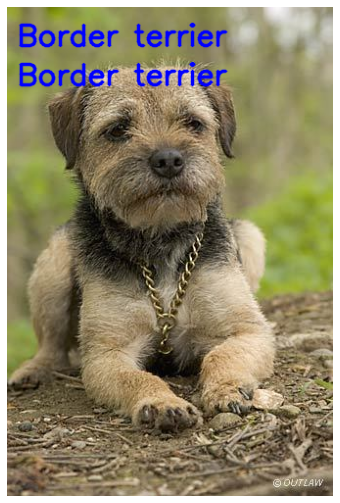

tensor(1, device='cuda:0')

In [ ]:
visualize_prediction(os.path.join("./data/", np.random.choice(val_dataset.image_names)),  model, 'val')

Найдем на картинках собак c помощью maskrcnn, произведем их сегментацию и детекцию. Применим маску и вырежем по детекшн bbox. Затем сохраним полученные картинки, с добавлением к имени _mask. И на них уже будем обучать сетку для классификации



In [ ]:
def get_detector_model():
    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        pretrained_backbone=True,
        progress=True, 
        num_classes=91, 
    )

  
    
    return model

In [ ]:
COCO_CLASS_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
device = torch.device("cuda:0") if args.gpu and torch.cuda.is_available() else torch.device("cpu")

In [ ]:
TRESHOLD_MASK = 0.05

In [ ]:
from torchvision import transforms

to_tensor = transforms.ToTensor()

def val_transform(img):
    img_tensor = to_tensor(img) # делаем тензор с 3 каналами из изображением
    return img_tensor.unsqueeze(0) # добавляем четвертую размерность  - перввое
    # измерение -  количество сеймплов в батче



In [ ]:
TRESHOLD_MASK = 0.05
def visualize_prediction_mask(file, model, device='cuda', verbose=True, thresh=0.0,
                         n_colors=None):
    #читаем файл, лучше чем opencv
    img = Image.open(file)
    img_tensor = val_transform(img)
    model.to(device)
    #eval режим
    model.eval()
    with torch.no_grad():
        predictions = model(img_tensor.to(device))  # list of size 1
    prediction = predictions[0]

    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features

    palette = sns.color_palette(None, n_colors)

    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    for i in range(len(prediction["boxes"])):
        
        x1, x2, x3, x4 = map(int, prediction["boxes"][i].tolist())
        label = int(prediction["labels"][i].cpu())
        if label != 18:
          continue
        #print(label)
        score = float(prediction["scores"][i].cpu())
        mask = prediction['masks'][i][0, :, :].cpu().numpy()
        name = COCO_CLASS_NAMES[label]
        color = palette[label]
        if verbose:
            if score > thresh:
                print ("Class: {}, Confidence: {}".format(name, score))
        if score > thresh:
            image = cv2.rectangle(img.copy(), (x1, x2), (x3, x4),
                                  np.array(color) * 255, 2)
            cv2.putText(image, name, (x1, x2-10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, np.array(color) * 255, 2)
            image_segmented = img.copy()
            image_segmented[mask < TRESHOLD_MASK] = (250, 250, 250)
            image_segmented = image_segmented[x2 : x4, x1 : x3]
            
            show_image(image_segmented)
    #show_image(image)
    return prediction

In [ ]:

# Просто показать картинку. С семинара
def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
model = get_detector_model()
# model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Class: dog, Confidence: 0.9868466258049011


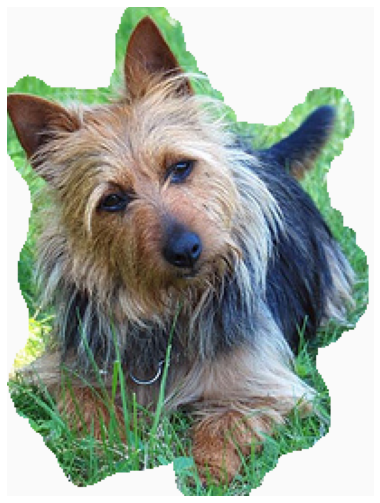

In [ ]:
_ = visualize_prediction_mask(os.path.join("./data/", np.random.choice(train_dataset.image_names)), model, device)

In [ ]:
def save_dog_file(file, mask_model, device='cuda', verbose=True, thresh=0.0, n_colors=None):
    #читаем файл, лучше чем opencv
    img1 = Image.open(file)
    if img1.mode != 'RGB':
      print("***")
    #print(img.mode)
    
    img_tensor = val_transform(img1)
    #print(img_tensor.shape)
    mask_model.to(device)
    #eval режим
    mask_model.eval()
    with torch.no_grad():
        predictions = mask_model(img_tensor.to(device))  # list of size 1
    prediction = predictions[0]

    if n_colors is None:
        n_colors = model.roi_heads.box_predictor.cls_score.out_features

    palette = sns.color_palette(None, n_colors)

    # visualize
    img = cv2.imread(file, cv2.COLOR_BGR2RGB)
    #show_image(img)
    score_max = 0
    found = False
    for i in range(len(prediction["boxes"])):
        
        x1, x2, x3, x4 = map(int, prediction["boxes"][i].tolist())
        label = int(prediction["labels"][i].cpu())
        if label != 18:
          continue
        #print(label)
        score = float(prediction["scores"][i].cpu())
        name = COCO_CLASS_NAMES[label]
        color = palette[label]
        #if verbose:
            #if score > thresh:
                #print ("Class: {}, Confidence: {}".format(name, score))
        if score > thresh:
            if score > score_max:
              score_max = score
              x1_max, x2_max, x3_max, x4_max = x1, x2, x3, x4
              mask = prediction['masks'][i][0, :, :].cpu().numpy()
              found = True
              #print(x1_max, x2_max, x3_max, x4_max)
    
    if (found == True) and (img1.mode == 'RGB') :
            if (mask.shape[0] != img.shape[0]) or(mask.shape[1] != img.shape[1])  :
                print("1111")
                image = img
                isWritten = cv2.imwrite(file + "_mask", image)  
                return
            #print("11")
            #image = cv2.rectangle(img.copy(), (x1_max, x2_max), (x3_max, x4_max),
                        #              np.array(color) * 255, 2)
            #show_image(image)
            #print(mask.shape, img.shape)
            img[mask < TRESHOLD_MASK] = (0, 0, 0)
            image = img[x2_max : x4_max, x1_max : x3_max,]
            
            #show_image(image)
            isWritten = cv2.imwrite(file + "_mask", image)      
    else:
            image = img
            isWritten = cv2.imwrite(file + "_mask", image)   
    #print(isWritten)                       
    #show_image(image)
    #return prediction

In [ ]:
import glob
class DogsDataset(Dataset):
    def __init__(self, root, transforms, split="train"):
        super(DogsDataset, self).__init__()
        self.root = root
        self.image_names = []
        self.transforms = transforms
        self.labels = []
        mask_model = get_detector_model()
        # model.load_state_dict(torch.load(DETECTOR_MODEL_PATH))
        mask_model.to(device);

        #dirs = glob.glob(os.path.join(root, f'{split}/*'))
        #print(dirs)
        dirs = ['n02099601', 'n02093754', 'n02089973', 'n02096294', 'n02088364', 'n02087394', 'n02086240', 'n02115641', 'n02105641', 'n02111889']

        files = glob.glob(os.path.join(root, f"{split}/*/*.JPEG"))
        
        #print(len(files))
        for filename in tqdm(files[:]):
           # print(filename)
            save_dog_file(filename, mask_model)
            
            self.image_names.append(filename[7:])
            #break
            
        if split == 'train':
            #dirs = [dirs[i][13:] for i in range(10)]
            #print(dirs)
            labels =  pd.read_csv(os.path.join(f"{root}/noisy_imagewoof.csv"))
            #print(labels.head())
            labels_dict = {k: dirs.index(v) for k, v in zip(labels['path'].values, labels['noisy_labels_0'].values)}
            #print(labels_dict)
        else:
            #dirs = [dirs[i][11:] for i in range(10)]
            #print(dirs)
            labels = [self.image_names[i][4:13]  for i in range(len(self.image_names))]
            #print(labels)
            labels_dict = {k: dirs.index(v) for k, v in zip(self.image_names, labels)}
            #print(labels_dict)
                 
                 
        self.labels_dict = labels_dict 
        
        
        for image_name in self.image_names:
            #print(filename)
           
            self.labels.append(self.labels_dict[image_name])
  
    def __getitem__(self, idx):
        
        sample = {}
        # if self.landmarks is not None:
        #     landmarks = self.landmarks[idx]
        #     sample["landmarks"] = landmarks

        # #print(self.image_names[idx])
        image = cv2.imread((os.path.join(self.root, self.image_names[idx])))
        #print(self.image_names[idx])
        # #print(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample["image"] = image
        #sample['label'] = self.labels_dict[self.image_names[idx]]
        sample['label'] = self.labels[idx]
        if self.transforms is not None:
             sample = self.transforms(sample)

        #print(sample)
        return sample

    def __len__(self):
        return len(self.image_names)

In [ ]:

train_dataset = DogsDataset('./data/', train_transforms, split="train")
val_dataset = DogsDataset('./data/', train_transforms, split="val")